# Training Pipeline

### Imports

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.optim import Adam
from torchvision.transforms import  Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop, Lambda
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics

In [2]:
num_workers = 0

device = torch.device("cpu")


### MacOS

Set start method to fork and device to metal

In [3]:
import torch.multiprocessing as mp
mp.set_start_method("fork", force=True)  # Ensure fork is used on macOS

device = torch.device("cpu")

if torch.mps.is_available():
    #torch.mps.set_buffer_capacity(1)
    #torch.mps.set_reuse_buffers(True)
    #torch.mps.initialize()
    device = torch.device("mps")
    num_workers = 11

### Linux

In [3]:
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA-Version:", torch.version.cuda)
print("GPU-Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Keine GPU gefunden")

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 19


CUDA verfügbar: True
CUDA-Version: 12.4
GPU-Name: NVIDIA GeForce RTX 3070 Ti


# Load Datasets

In [4]:
# Dataset Path
DATASET_PATHS = ["../Dataset/MIT_local_data/MIT-Dataset"]
DATASET_PATHS_TEST = ["../Dataset/custom_local_data"]
DATASET_PATHS_VALID = [] # Not used yet
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
SEED = 42

Set seed 

In [5]:
from lightning.pytorch import seed_everything

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
seed_everything(SEED)

Seed set to 42


42

In [6]:
# Custom Dataset
def load_image_label(file_name, dataset_path):
    """Helper function to load image and label from a given file."""
    # Load Image
    image_path = os.path.join(dataset_path, file_name)
    image = Image.open(image_path).resize(IMAGE_SIZE)
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize
    # Load Label
    txt_file = file_name.replace(".jpg", ".txt")
    txt_path = os.path.join(dataset_path, txt_file)
    label = None
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            lines = f.readlines()
            if len(lines) >= 2:
                try:
                    label = float(lines[1].split()[-1])
                except ValueError:
                    print(f"Fehler beim Lesen des Preises in Datei: {txt_path}")
    if label is None:
        raise ValueError(f"Label konnte nicht geladen werden: {txt_file}")
    return image, label

## Custom augmentation

In [7]:
import random
from PIL import Image, ImageEnhance

def custom_augmentation(image):
    
    
    noise_factor = random.uniform(0.01, 0.03)
    image = add_random_noise(image, noise_factor)
    
    return image

def add_random_noise(image, noise_factor=0.1):
    """
    Fügt zufälliges Rauschen zu einem Bild hinzu.
    """
    np_image = np.array(image)  # Konvertiere das Bild zu einem numpy-Array
    noise = np.random.randn(*np_image.shape) * noise_factor  # Erzeuge Rauschen
    noisy_image = np_image + noise * 255  # Skaliere das Rauschen zu den Bildwerten
    noisy_image = np.clip(noisy_image, 0, 255)  # Begrenze den Wertebereich
    return Image.fromarray(np.uint8(noisy_image))  # Konvertiere zurück zu einem PIL-Image


In [8]:

class ImagePriceDataset(Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.files = []
        for dataset_path in dataset_paths:
            if not os.path.exists(dataset_path):
                raise ValueError(f"Path {dataset_path} doesn't exist.")
            for f in os.listdir(dataset_path):
                if f.endswith(".jpg"):
                    self.files.append((f, dataset_path))
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name, dataset_path = self.files[idx]
        image, label = load_image_label(file_name, dataset_path)

        # Wenn das Bild im float32 Format vorliegt, skaliere es und wandle es in uint8 um
        if image.dtype == np.float32:
            image = (image * 255).astype(np.uint8)  # Skalieren auf [0, 255] und in uint8 umwandeln

        # Konvertiere das numpy-Array in ein PIL-Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)
    
# Transforms
transform = Compose([
    #Resize(IMAGE_SIZE),               # Skaliere die Bilder auf die gewünschte Größe
    Lambda(lambda x: custom_augmentation(x)),
    RandomHorizontalFlip(p=0.5),       # Zufälliges horizontales Spiegeln mit 50% Wahrscheinlichkeit
    RandomRotation(degrees=180),        # Zufällige Rotation um bis zu ±15 Grad
    RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.0)),
    ColorJitter(brightness=0.03,        # Zufällige Anpassung der Helligkeit
                contrast=0.1,          # Kontrast
                saturation=0.1,        # Sättigung
                hue=0.03),              # Farbton
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

transform_test = Compose([
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

# Dataset
train_dataset = ImagePriceDataset(DATASET_PATHS, transform=transform)
test_dataset = ImagePriceDataset(DATASET_PATHS_TEST, transform_test)
# Train-Valid Split
if len(DATASET_PATHS_VALID) > 0:
    val_dataset = ImagePriceDataset(DATASET_PATHS_VALID, transform=transform)
else:    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


## Test Augmentation

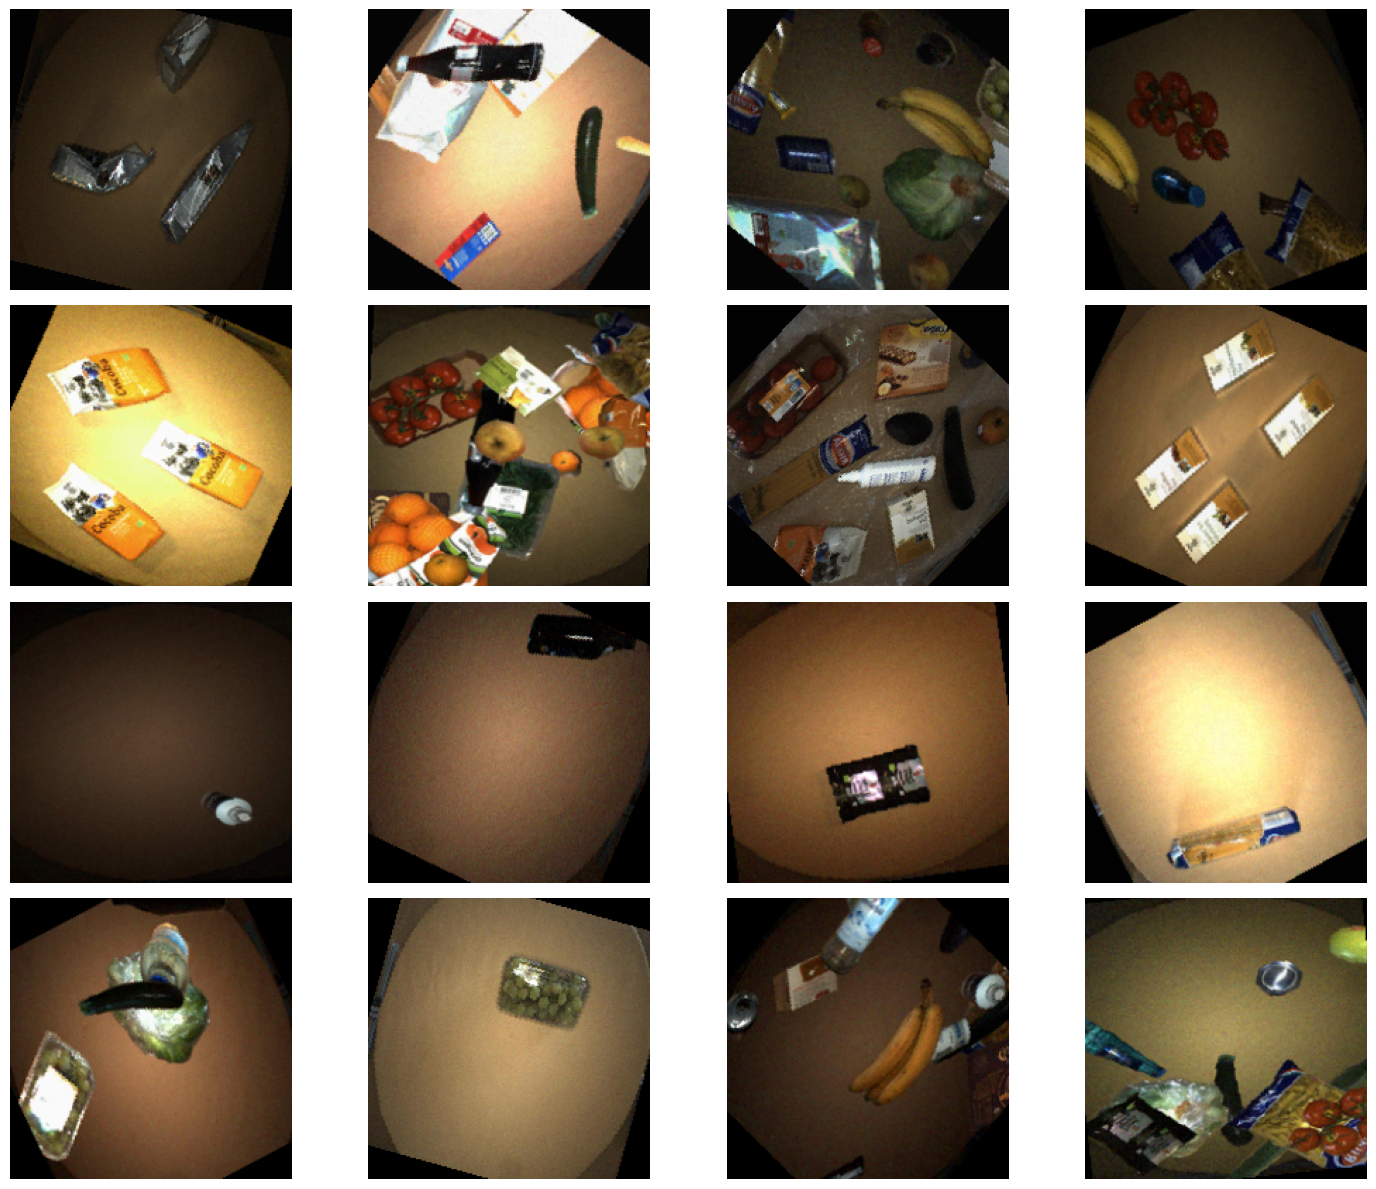

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Funktion zum Anzeigen von Bildern
def imshow(image, ax=None):
    # Wenn kein Ax angegeben wird, erstelle eine neue Achse
    if ax is None:
        fig, ax = plt.subplots()
        
    # Wandle den Tensor in ein NumPy-Array um und skaliere die Werte zurück auf [0, 1]
    image = image.permute(1, 2, 0).numpy()  # Von (C, H, W) nach (H, W, C)
    image = np.clip(image, 0, 1)  # Begrenze den Wertebereich auf [0, 1]
    
    ax.imshow(image)
    ax.axis('off')

# Hole ein Batch von Bildern aus dem DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Zeige die ersten 5 Bilder im Batch
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4 Zeilen, 5 Spalten
axes = axes.flatten()  # Flatten der 2D Achsenmatrix, um sie einfach zu durchlaufen

# Zeige die Bilder
for i in range(16):
    imshow(images[i], axes[i])  # Stelle jedes Bild in der jeweiligen Achse dar

# Zeige die Bilder
plt.tight_layout()  # Optimiert das Layout für bessere Übersicht
plt.show()


## Weights & Biases

## Build Model

In [10]:
# Lightning Module
class RegressionModel(pl.LightningModule):
    def __init__(self, num_layers=6, num_filters=[32,32,32,32,32,32], pooling = [[1,2,3],[4]], kernel_size=3, learning_rate=1e-3):
        super().__init__()
        layers = []
        in_channels = 3  # Input-Kanäle, z. B. RGB-Bilder
        self.learning_rate = learning_rate
        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, num_filters[i], kernel_size, padding="same", stride=1))
            layers.append(nn.ReLU())
            if i in pooling[0]: 
                layers.append(nn.MaxPool2d(kernel_size=2))
            elif i in pooling[1]:
                layers.append(nn.MaxPool2d(kernel_size=3))

            in_channels = num_filters[i]
        
        layers.append(nn.Flatten())
        layers.append(nn.Linear(num_filters[len(num_filters)-1]* 64, 100))  # Passe die Eingabegröße entsprechend an
        layers.append(nn.ReLU())
        layers.append(nn.Linear(100, 50)) 
        layers.append(nn.ReLU())
        layers.append(nn.Linear(50, 1))  # Regression Output
        
        self.model = nn.Sequential(*layers)
        self.criterion = nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)  # Entferne die überflüssige Dimension
        loss = self.criterion(y_pred, y)

        # Berechne zusätzliche Metriken
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Logs für Progress-Bar und Training
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_mae", mae, prog_bar=True, on_epoch=True)
        self.log("train_mse", mse, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)  # Entferne die überflüssige Dimension
        loss = self.criterion(y_pred, y)

        # Berechne zusätzliche Metriken
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Logs für Validation
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_mae", mae, prog_bar=True, on_epoch=True)
        self.log("val_mse", mse, prog_bar=True, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)
        loss = self.criterion(y_pred, y)
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mae", mae, prog_bar=True)
        self.log("test_mse", mse, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Erstelle einen Scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.96)
        # Alternativ: andere Scheduler wie CosineAnnealingLR, ReduceLROnPlateau, etc.
        
        return [optimizer], [scheduler]
    
    #def train_dataloader(self):

        #return super().train_dataloader()
    
    #def val_dataloader(self):


## Training

### Callbacks:

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Track validation loss
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Checkpoint file name
    save_top_k=1,  # Save only the best model (lowest val_loss)
    mode='min',  # We are minimizing validation loss
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    mode="min",      
    min_delta=0.1,
    patience=5,          
    verbose=True       
)

/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 990 K  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
--------------------------------------------------------
990 K     Trainable params
0         Non-trainable params
990 K     Total params
3.962     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6         [-1, 64, 100, 100]          36,928
              ReLU-7         [-1, 64, 100, 100]               0
         MaxPool2d-8           [-1, 64, 50, 50]               0
            Conv2d-9           [-1, 64, 50, 50]          36,928
             ReLU-10           [-1, 64, 50, 50]               0
        MaxPool2d-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,928
             ReLU-13           [-1, 64, 25, 25]               0
        MaxPool2d-14             [-1, 6

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 450/450 [00:47<00:00,  9.44it/s, v_num=gonb, train_loss_step=51.60, train_mae_step=4.620, train_mse_step=51.60, val_loss=18.30, val_mae=3.220, val_mse=18.30, train_loss_epoch=22.50, train_mae_epoch=3.430, train_mse_epoch=22.50]
Best model saved at: /home/torge/TinyML-MT-data/training-code/checkpoints/MIT-Dataset_10Jan-17:21:06.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 218/218 [00:03<00:00, 56.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           63.384098052978516
        test_mae             6.350120544433594
        test_mse            63.384098052978516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


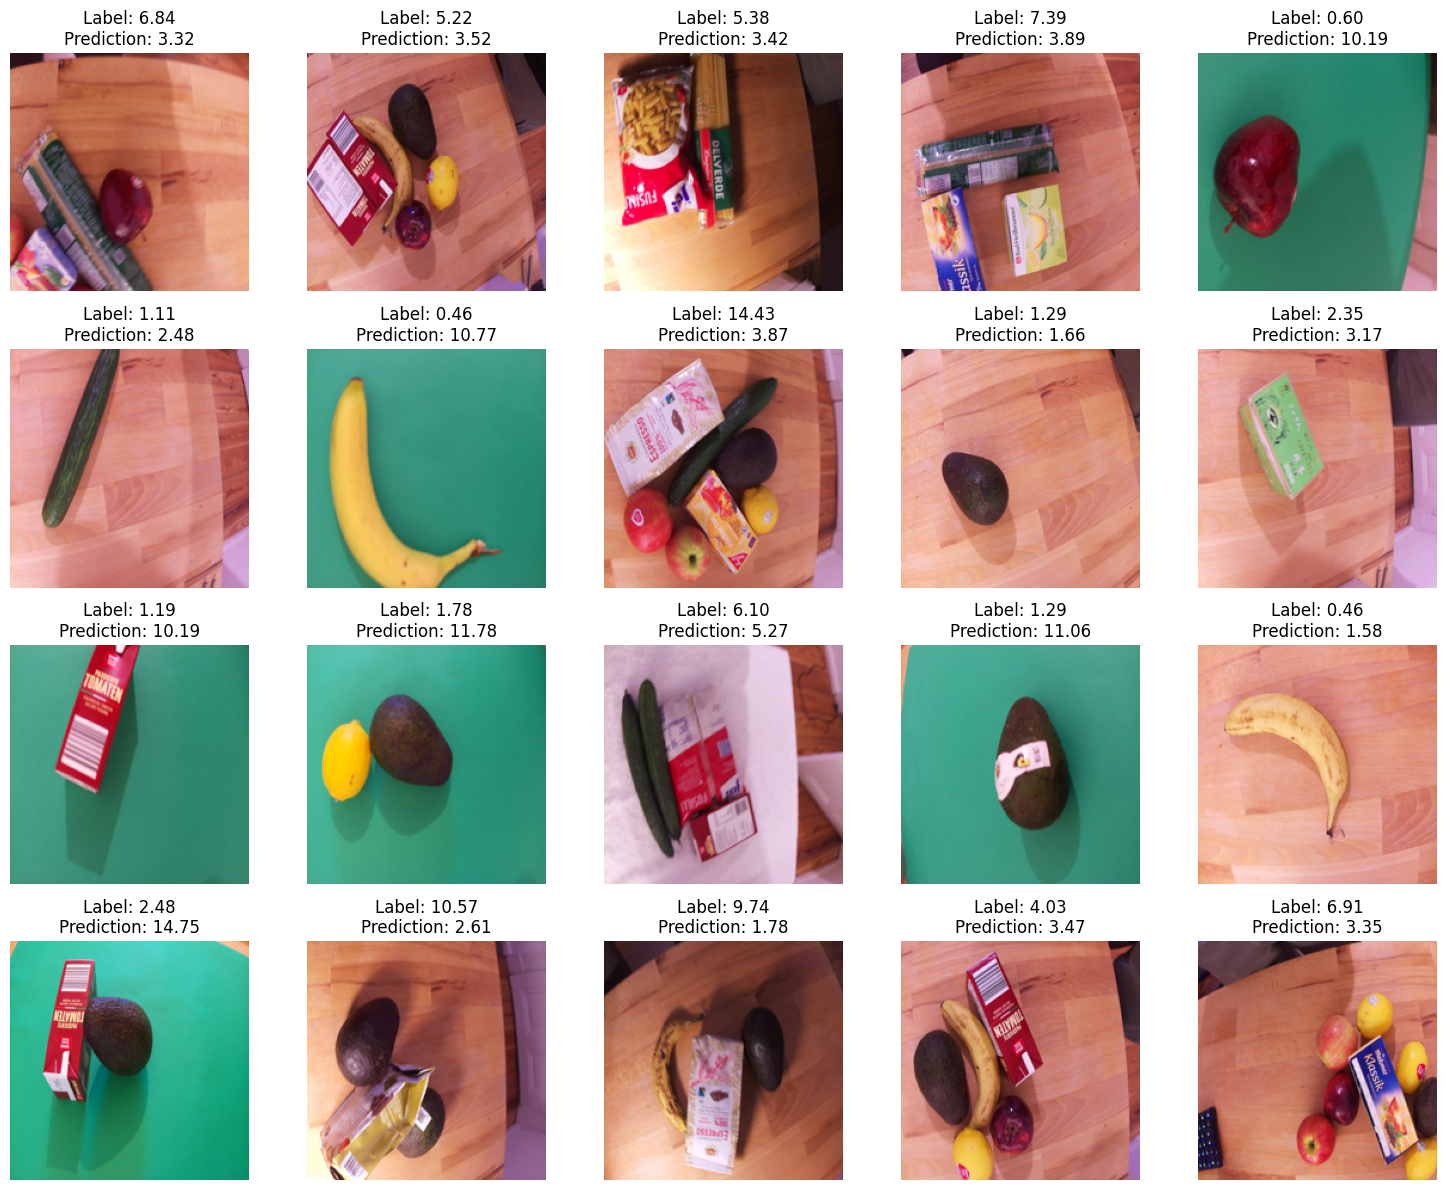

In [13]:

from lightning.pytorch.loggers import WandbLogger
import wandb
from datetime import datetime
# WANDB stuff
#
# Sort the dataset names alphabetically
dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))

group = "Regression-"+dataset_names
name = dataset_names+"_"+datetime.now().strftime("%d%b-%H:%M:%S")

wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Wähle automatisch GPU, falls verfügbar

model = RegressionModel(num_filters= [64, 64, 64, 64, 64, 96, 96, 96], num_layers=8, kernel_size=3, learning_rate= 0.001).to(device)

# Verschiebe das Modell auf das Gerät
summary(model, input_size=(3, 200, 200))

# Log additional hyperparameters
wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED})

# Create a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=1, logger=wandb_logger, callbacks=[checkpoint_callback], fast_dev_run=False, accelerator=str(device), devices=1)

# Model Training
trainer.fit(model, train_loader, val_loader) 

# Load the best checkpoint (lowest validation loss)
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

# Load the best model for testing
model = RegressionModel.load_from_checkpoint(best_model_path)
# Model Testing
trainer.test(model, test_loader)

# Metrics and predictions
metrics = trainer.callback_metrics

def show_predictions(model, test_dataset, num_samples=20):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    samples = random.sample(range(len(test_dataset)), num_samples)  # Wähle zufällig Samples aus
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Erstelle ein 4x5 Grid für die Bilder
    
    for i, idx in enumerate(samples):
        image, label = test_dataset[idx]  # Lade das Bild und das Label
        image_tensor = image.unsqueeze(0).to(model.device)  # Füge Batch-Dimension hinzu und verschiebe auf GPU/CPU
        
        # Vorhersage erzeugen
        with torch.no_grad():
            prediction = model(image_tensor).cpu().item()
        
        # Bild anzeigen
        ax = axes[i // 5, i % 5]
        ax.imshow(image.permute(1, 2, 0))  # Konvertiere das Tensor-Bild in HWC-Format
        ax.set_title(f"Label: {label:.2f}\nPrediction: {prediction:.2f}")
        ax.axis("off")
    
    plt.tight_layout()

    try:
        wandb.log({"predictions": wandb.Image(plt)})
    except Exception as e:
        print(f"Couldn't log predictions to wandb: {e}")

    plt.show()

show_predictions(model, test_dataset)

wandb.finish()


/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/torge/TinyML-MT-data/training-code/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 257 K  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
--------------------------

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
            Conv2d-3         [-1, 32, 200, 200]           9,248
              ReLU-4         [-1, 32, 200, 200]               0
         MaxPool2d-5         [-1, 32, 100, 100]               0
            Conv2d-6         [-1, 32, 100, 100]           9,248
              ReLU-7         [-1, 32, 100, 100]               0
         MaxPool2d-8           [-1, 32, 50, 50]               0
            Conv2d-9           [-1, 32, 50, 50]           9,248
             ReLU-10           [-1, 32, 50, 50]               0
        MaxPool2d-11           [-1, 32, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]           9,248
             ReLU-13           [-1, 32, 25, 25]               0
        MaxPool2d-14             [-1, 3

Metric val_loss improved. New best score: 20.441


Epoch 1: 100%|██████████| 450/450 [00:41<00:00, 10.84it/s, v_num=ejkj, train_loss_step=16.60, train_mae_step=2.960, train_mse_step=16.60, val_loss=17.10, val_mae=2.900, val_mse=17.10, train_loss_epoch=18.10, train_mae_epoch=2.960, train_mse_epoch=18.10]

Metric val_loss improved by 3.382 >= min_delta = 0.1. New best score: 17.059


Epoch 2: 100%|██████████| 450/450 [00:40<00:00, 10.98it/s, v_num=ejkj, train_loss_step=7.240, train_mae_step=1.770, train_mse_step=7.240, val_loss=16.70, val_mae=2.670, val_mse=16.70, train_loss_epoch=17.10, train_mae_epoch=2.830, train_mse_epoch=17.10]

Metric val_loss improved by 0.389 >= min_delta = 0.1. New best score: 16.670


Epoch 3: 100%|██████████| 450/450 [00:41<00:00, 10.97it/s, v_num=ejkj, train_loss_step=18.60, train_mae_step=3.010, train_mse_step=18.60, val_loss=15.90, val_mae=2.840, val_mse=15.90, train_loss_epoch=16.70, train_mae_epoch=2.780, train_mse_epoch=16.70]

Metric val_loss improved by 0.794 >= min_delta = 0.1. New best score: 15.875


Epoch 6: 100%|██████████| 450/450 [00:43<00:00, 10.31it/s, v_num=ejkj, train_loss_step=28.40, train_mae_step=3.840, train_mse_step=28.40, val_loss=15.20, val_mae=2.630, val_mse=15.20, train_loss_epoch=16.00, train_mae_epoch=2.700, train_mse_epoch=16.00]

Metric val_loss improved by 0.649 >= min_delta = 0.1. New best score: 15.226


Epoch 8: 100%|██████████| 450/450 [00:42<00:00, 10.69it/s, v_num=ejkj, train_loss_step=9.960, train_mae_step=2.370, train_mse_step=9.960, val_loss=15.10, val_mae=2.530, val_mse=15.10, train_loss_epoch=15.50, train_mae_epoch=2.660, train_mse_epoch=15.50]

Metric val_loss improved by 0.140 >= min_delta = 0.1. New best score: 15.085


Epoch 9: 100%|██████████| 450/450 [00:44<00:00, 10.09it/s, v_num=ejkj, train_loss_step=18.00, train_mae_step=3.290, train_mse_step=18.00, val_loss=14.70, val_mae=2.680, val_mse=14.70, train_loss_epoch=15.30, train_mae_epoch=2.640, train_mse_epoch=15.30]

Metric val_loss improved by 0.408 >= min_delta = 0.1. New best score: 14.677


Epoch 11: 100%|██████████| 450/450 [00:48<00:00,  9.29it/s, v_num=ejkj, train_loss_step=8.330, train_mae_step=2.110, train_mse_step=8.330, val_loss=13.70, val_mae=2.470, val_mse=13.70, train_loss_epoch=14.70, train_mae_epoch=2.600, train_mse_epoch=14.70]

Metric val_loss improved by 0.991 >= min_delta = 0.1. New best score: 13.686


Epoch 14: 100%|██████████| 450/450 [00:44<00:00, 10.21it/s, v_num=ejkj, train_loss_step=13.30, train_mae_step=2.380, train_mse_step=13.30, val_loss=11.90, val_mae=2.310, val_mse=11.90, train_loss_epoch=12.50, train_mae_epoch=2.410, train_mse_epoch=12.50]

Metric val_loss improved by 1.772 >= min_delta = 0.1. New best score: 11.914


Epoch 17: 100%|██████████| 450/450 [00:42<00:00, 10.70it/s, v_num=ejkj, train_loss_step=8.870, train_mae_step=2.380, train_mse_step=8.870, val_loss=11.10, val_mae=2.360, val_mse=11.10, train_loss_epoch=11.40, train_mae_epoch=2.300, train_mse_epoch=11.40]

Metric val_loss improved by 0.765 >= min_delta = 0.1. New best score: 11.149


Epoch 19: 100%|██████████| 450/450 [00:42<00:00, 10.59it/s, v_num=ejkj, train_loss_step=5.390, train_mae_step=1.650, train_mse_step=5.390, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

Metric val_loss improved by 0.426 >= min_delta = 0.1. New best score: 10.723


Epoch 20:   0%|          | 0/450 [00:00<?, ?it/s, v_num=ejkj, train_loss_step=5.390, train_mae_step=1.650, train_mse_step=5.390, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]          

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>
Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 0:  17%|█▋        | 78/450 [45:38<3:37:42,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>
Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 20:   0%|          | 1/450 [00:02<17:50,  0.42it/s, v_num=ejkj, train_loss_step=8.290, train_mae_step=2.240, train_mse_step=8.290, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>


Epoch 20:   0%|          | 2/450 [00:02<09:01,  0.83it/s, v_num=ejkj, train_loss_step=8.290, train_mae_step=2.240, train_mse_step=8.290, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():

Epoch 20:   0%|          | 2/450 [00:02<09:07,  0.82it/s, v_num=ejkj, train_loss_step=6.090, train_mae_step=1.730, train_mse_step=6.090, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]


  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 0:  17%|█▋        | 78/450 [45:40<3:37:50,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>
Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>: can only test a child process
Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    

Epoch 0:  17%|█▋        | 78/450 [45:40<3:37:51,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]


self._shutdown_workers()
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 0:  17%|█▋        | 78/450 [45:40<3:37:51,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>

Epoch 20:   1%|          | 3/450 [00:02<07:26,  1.00it/s, v_num=ejkj, train_loss_step=6.090, train_mae_step=1.730, train_mse_step=6.090, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]


<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>Exception ignored in: 


Epoch 20:   1%|          | 3/450 [00:03<07:28,  1.00it/s, v_num=ejkj, train_loss_step=25.40, train_mae_step=3.200, train_mse_step=25.40, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>    
Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()      File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive



Epoch 0:  17%|█▋        | 78/450 [45:41<3:37:53,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]


AssertionError: can only test a child processcan only test a child process



Epoch 0:  17%|█▋        | 78/450 [45:41<3:37:53,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090><function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
      File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()  File "/home/torge/TinyML-MT-dat

Epoch 0:  17%|█▋        | 78/450 [45:41<3:37:53,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]


: 
can only test a child process

Epoch 0:  17%|█▋        | 78/450 [45:41<3:37:53,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]

Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__



Epoch 20:   1%|          | 4/450 [00:03<06:00,  1.24it/s, v_num=ejkj, train_loss_step=25.40, train_mae_step=3.200, train_mse_step=25.40, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

Epoch 0:  17%|█▋        | 78/450 [45:41<3:37:54,  0.03it/s, v_num=ejkj, train_loss_step=22.10, train_mae_step=3.670, train_mse_step=22.10]

    self._shutdown_workers()


  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers


Epoch 20:   1%|          | 4/450 [00:03<06:02,  1.23it/s, v_num=ejkj, train_loss_step=11.40, train_mae_step=2.320, train_mse_step=11.40, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 20:   3%|▎         | 13/450 [00:03<02:07,  3.43it/s, v_num=ejkj, train_loss_step=6.150, train_mae_step=1.810, train_mse_step=6.150, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6aa0d55090>
Traceback (most recent call last):
  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()


Epoch 20:   3%|▎         | 14/450 [00:03<01:58,  3.68it/s, v_num=ejkj, train_loss_step=6.150, train_mae_step=1.810, train_mse_step=6.150, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

  File "/home/torge/TinyML-MT-data/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive


Epoch 20:   3%|▎         | 14/450 [00:03<01:59,  3.66it/s, v_num=ejkj, train_loss_step=6.150, train_mae_step=1.730, train_mse_step=6.150, val_loss=10.70, val_mae=2.140, val_mse=10.70, train_loss_epoch=10.80, train_mae_epoch=2.230, train_mse_epoch=10.80]

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 20: 100%|██████████| 450/450 [00:43<00:00, 10.25it/s, v_num=ejkj, train_loss_step=7.360, train_mae_step=2.220, train_mse_step=7.360, val_loss=10.20, val_mae=2.160, val_mse=10.20, train_loss_epoch=10.60, train_mae_epoch=2.210, train_mse_epoch=10.60]

Metric val_loss improved by 0.544 >= min_delta = 0.1. New best score: 10.179


Epoch 22: 100%|██████████| 450/450 [00:43<00:00, 10.44it/s, v_num=ejkj, train_loss_step=9.470, train_mae_step=2.150, train_mse_step=9.470, val_loss=9.590, val_mae=2.120, val_mse=9.590, train_loss_epoch=10.00, train_mae_epoch=2.150, train_mse_epoch=10.00]

Metric val_loss improved by 0.587 >= min_delta = 0.1. New best score: 9.593


Epoch 26: 100%|██████████| 450/450 [00:42<00:00, 10.69it/s, v_num=ejkj, train_loss_step=3.620, train_mae_step=1.310, train_mse_step=3.620, val_loss=9.020, val_mae=2.030, val_mse=9.020, train_loss_epoch=9.380, train_mae_epoch=2.080, train_mse_epoch=9.380]

Metric val_loss improved by 0.575 >= min_delta = 0.1. New best score: 9.018


Epoch 31: 100%|██████████| 450/450 [00:43<00:00, 10.33it/s, v_num=ejkj, train_loss_step=16.10, train_mae_step=2.390, train_mse_step=16.10, val_loss=8.920, val_mae=2.020, val_mse=8.920, train_loss_epoch=8.820, train_mae_epoch=2.010, train_mse_epoch=8.820]

Monitored metric val_loss did not improve in the last 5 records. Best score: 9.018. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 450/450 [00:43<00:00, 10.33it/s, v_num=ejkj, train_loss_step=16.10, train_mae_step=2.390, train_mse_step=16.10, val_loss=8.920, val_mae=2.020, val_mse=8.920, train_loss_epoch=8.820, train_mae_epoch=2.010, train_mse_epoch=8.820]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 218/218 [00:04<00:00, 54.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            100.1070785522461
        test_mae             7.712884426116943
        test_mse             100.1070785522461
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


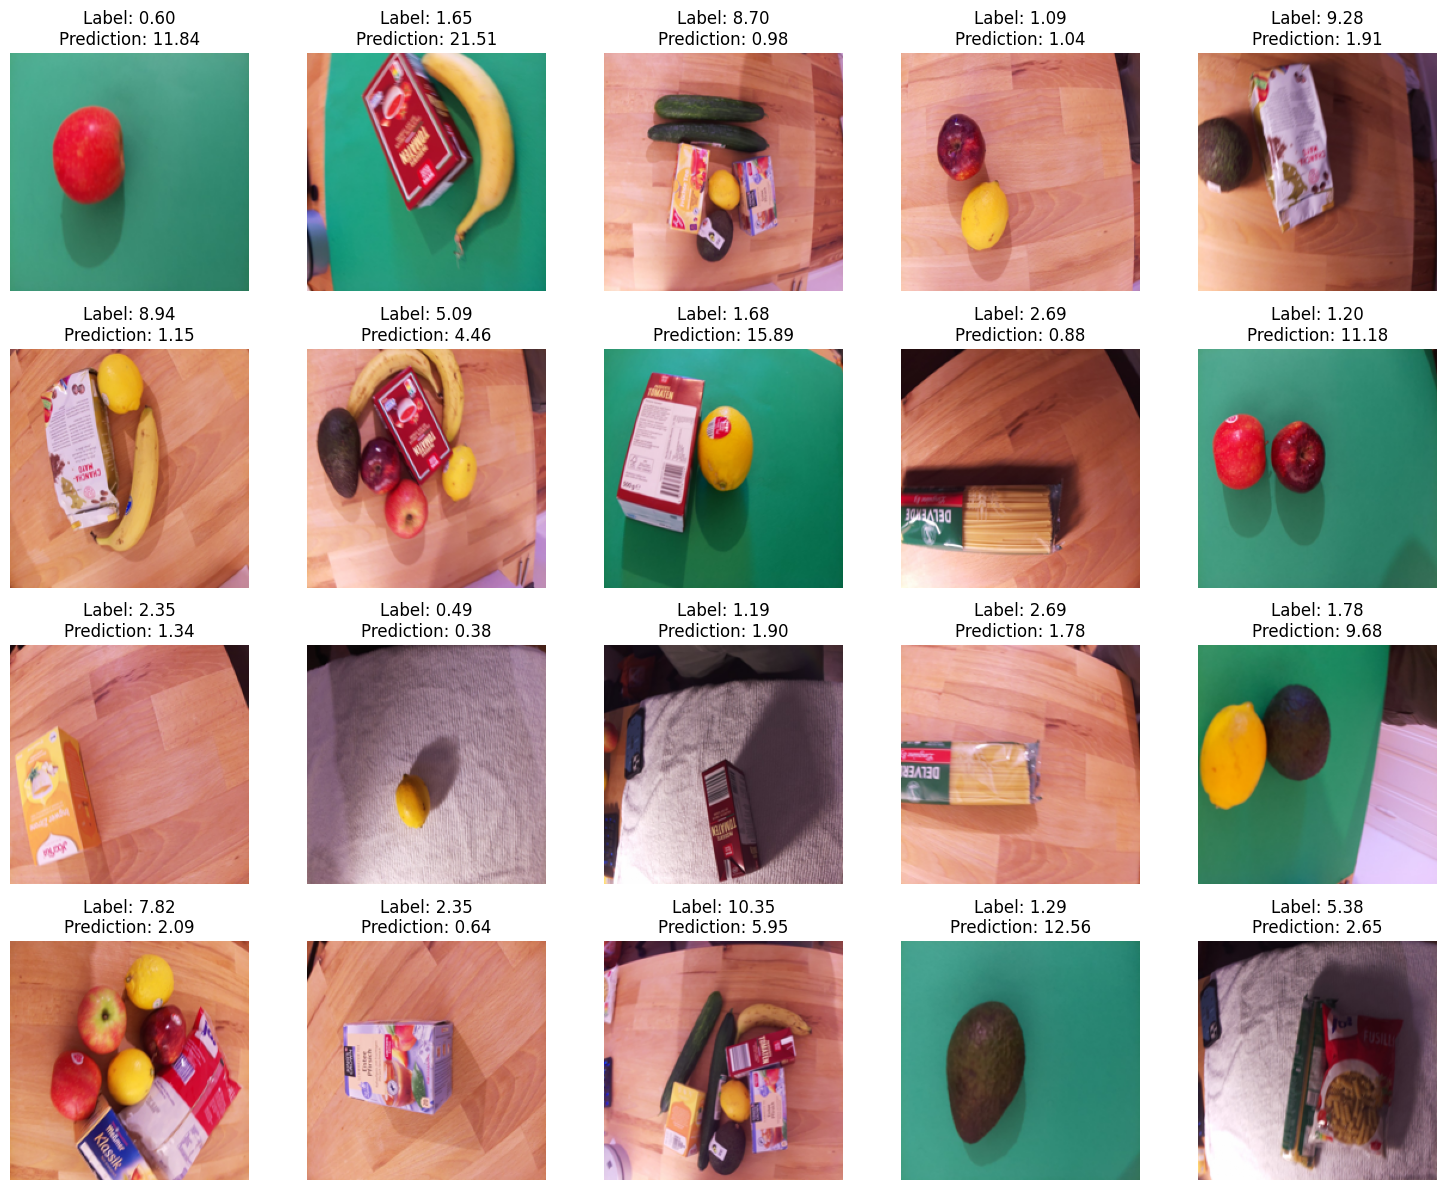

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 83.9 K | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
--------------------------------------------------------
83.9 K    Trainable params
0         Non-trainable params
83.9 K    Total params
0.336     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
            Conv2d-3         [-1, 32, 200, 200]           9,248
              ReLU-4         [-1, 32, 200, 200]               0
         MaxPool2d-5         [-1, 32, 100, 100]               0
            Conv2d-6         [-1, 32, 100, 100]           9,248
              ReLU-7         [-1, 32, 100, 100]               0
         MaxPool2d-8           [-1, 32, 50, 50]               0
            Conv2d-9           [-1, 16, 50, 50]           4,624
             ReLU-10           [-1, 16, 50, 50]               0
        MaxPool2d-11           [-1, 16, 25, 25]               0
           Conv2d-12           [-1, 16, 25, 25]           2,320
             ReLU-13           [-1, 16, 25, 25]               0
        MaxPool2d-14             [-1, 1

Metric val_loss improved. New best score: 18.569


Epoch 1: 100%|██████████| 450/450 [00:43<00:00, 10.31it/s, v_num=ejkj, train_loss_step=6.300, train_mae_step=2.050, train_mse_step=6.300, val_loss=17.50, val_mae=2.970, val_mse=17.50, train_loss_epoch=18.70, train_mae_epoch=3.050, train_mse_epoch=18.70]

Metric val_loss improved by 1.056 >= min_delta = 0.1. New best score: 17.514


Epoch 2: 100%|██████████| 450/450 [00:42<00:00, 10.62it/s, v_num=ejkj, train_loss_step=8.750, train_mae_step=2.330, train_mse_step=8.750, val_loss=17.10, val_mae=2.820, val_mse=17.10, train_loss_epoch=17.90, train_mae_epoch=2.940, train_mse_epoch=17.90]

Metric val_loss improved by 0.406 >= min_delta = 0.1. New best score: 17.108


Epoch 3: 100%|██████████| 450/450 [00:45<00:00,  9.92it/s, v_num=ejkj, train_loss_step=16.30, train_mae_step=3.390, train_mse_step=16.30, val_loss=16.20, val_mae=2.810, val_mse=16.20, train_loss_epoch=17.40, train_mae_epoch=2.870, train_mse_epoch=17.40]

Metric val_loss improved by 0.902 >= min_delta = 0.1. New best score: 16.206


Epoch 6: 100%|██████████| 450/450 [00:43<00:00, 10.44it/s, v_num=ejkj, train_loss_step=11.90, train_mae_step=2.480, train_mse_step=11.90, val_loss=16.00, val_mae=2.640, val_mse=16.00, train_loss_epoch=16.70, train_mae_epoch=2.780, train_mse_epoch=16.70]

Metric val_loss improved by 0.210 >= min_delta = 0.1. New best score: 15.996


Epoch 7: 100%|██████████| 450/450 [00:43<00:00, 10.34it/s, v_num=ejkj, train_loss_step=18.00, train_mae_step=3.590, train_mse_step=18.00, val_loss=15.70, val_mae=2.870, val_mse=15.70, train_loss_epoch=16.30, train_mae_epoch=2.750, train_mse_epoch=16.30]

Metric val_loss improved by 0.252 >= min_delta = 0.1. New best score: 15.744


Epoch 8: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s, v_num=ejkj, train_loss_step=6.670, train_mae_step=2.040, train_mse_step=6.670, val_loss=15.20, val_mae=2.760, val_mse=15.20, train_loss_epoch=16.50, train_mae_epoch=2.750, train_mse_epoch=16.50]

Metric val_loss improved by 0.548 >= min_delta = 0.1. New best score: 15.196


Epoch 13: 100%|██████████| 450/450 [00:42<00:00, 10.71it/s, v_num=ejkj, train_loss_step=12.80, train_mae_step=2.430, train_mse_step=12.80, val_loss=15.50, val_mae=2.900, val_mse=15.50, train_loss_epoch=15.30, train_mae_epoch=2.650, train_mse_epoch=15.30]

Monitored metric val_loss did not improve in the last 5 records. Best score: 15.196. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 450/450 [00:42<00:00, 10.71it/s, v_num=ejkj, train_loss_step=12.80, train_mae_step=2.430, train_mse_step=12.80, val_loss=15.50, val_mae=2.900, val_mse=15.50, train_loss_epoch=15.30, train_mae_epoch=2.650, train_mse_epoch=15.30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 218/218 [00:03<00:00, 57.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             23.82568359375
        test_mae            3.2208659648895264
        test_mse              23.82568359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


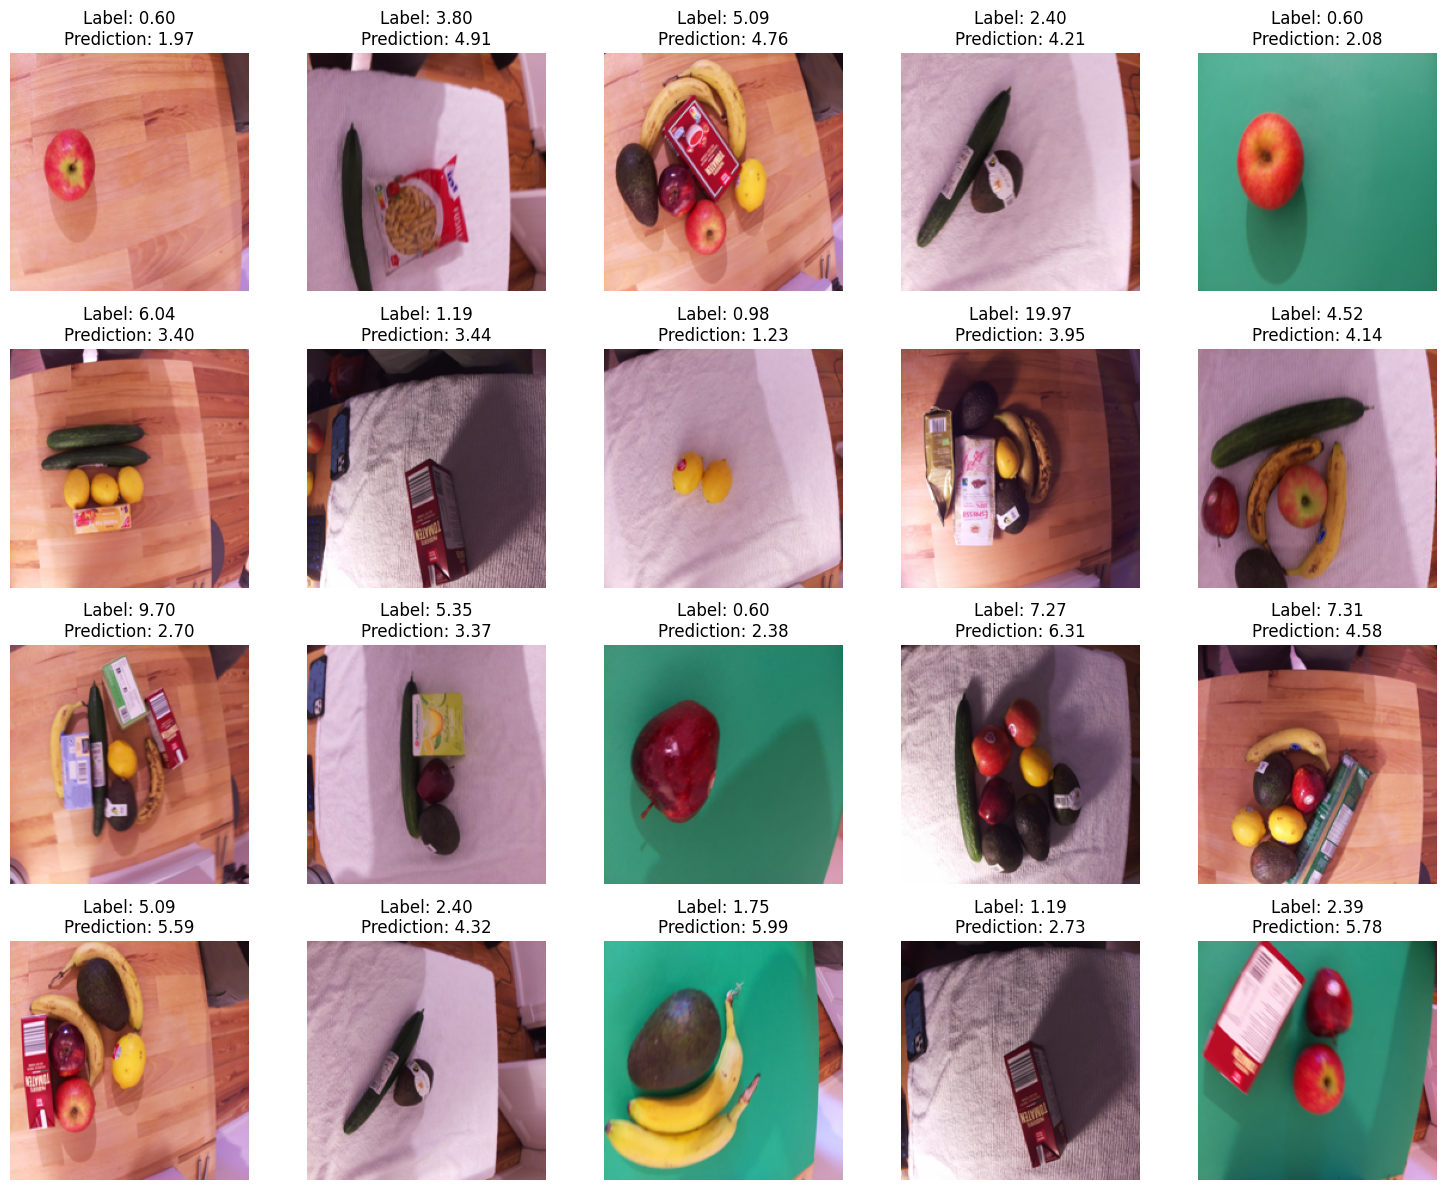

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 851 K  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
--------------------------------------------------------
851 K     Trainable params
0         Non-trainable params
851 K     Total params
3.405     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          18,496
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6         [-1, 64, 100, 100]          36,928
              ReLU-7         [-1, 64, 100, 100]               0
         MaxPool2d-8           [-1, 64, 50, 50]               0
            Conv2d-9           [-1, 64, 50, 50]          36,928
             ReLU-10           [-1, 64, 50, 50]               0
        MaxPool2d-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 96, 25, 25]          55,392
             ReLU-13           [-1, 96, 25, 25]               0
        MaxPool2d-14             [-1, 9

Metric val_loss improved. New best score: 18.607


Epoch 1: 100%|██████████| 450/450 [00:42<00:00, 10.50it/s, v_num=ejkj, train_loss_step=8.130, train_mae_step=2.100, train_mse_step=8.130, val_loss=17.30, val_mae=2.900, val_mse=17.30, train_loss_epoch=19.20, train_mae_epoch=3.060, train_mse_epoch=19.20]

Metric val_loss improved by 1.260 >= min_delta = 0.1. New best score: 17.346


Epoch 2: 100%|██████████| 450/450 [00:42<00:00, 10.54it/s, v_num=ejkj, train_loss_step=20.70, train_mae_step=3.080, train_mse_step=20.70, val_loss=16.50, val_mae=2.710, val_mse=16.50, train_loss_epoch=18.00, train_mae_epoch=2.940, train_mse_epoch=18.00]

Metric val_loss improved by 0.831 >= min_delta = 0.1. New best score: 16.515


Epoch 4: 100%|██████████| 450/450 [00:42<00:00, 10.49it/s, v_num=ejkj, train_loss_step=6.140, train_mae_step=2.120, train_mse_step=6.140, val_loss=15.70, val_mae=2.710, val_mse=15.70, train_loss_epoch=16.70, train_mae_epoch=2.780, train_mse_epoch=16.70]

Metric val_loss improved by 0.815 >= min_delta = 0.1. New best score: 15.701


Epoch 7: 100%|██████████| 450/450 [00:43<00:00, 10.37it/s, v_num=ejkj, train_loss_step=11.90, train_mae_step=2.420, train_mse_step=11.90, val_loss=14.90, val_mae=2.580, val_mse=14.90, train_loss_epoch=15.70, train_mae_epoch=2.680, train_mse_epoch=15.70]

Metric val_loss improved by 0.802 >= min_delta = 0.1. New best score: 14.899


Epoch 8: 100%|██████████| 450/450 [00:43<00:00, 10.32it/s, v_num=ejkj, train_loss_step=18.30, train_mae_step=2.930, train_mse_step=18.30, val_loss=14.70, val_mae=2.660, val_mse=14.70, train_loss_epoch=15.40, train_mae_epoch=2.650, train_mse_epoch=15.40]

Metric val_loss improved by 0.225 >= min_delta = 0.1. New best score: 14.673


Epoch 9: 100%|██████████| 450/450 [00:43<00:00, 10.33it/s, v_num=ejkj, train_loss_step=12.10, train_mae_step=3.120, train_mse_step=12.10, val_loss=14.10, val_mae=2.600, val_mse=14.10, train_loss_epoch=15.20, train_mae_epoch=2.640, train_mse_epoch=15.20]

Metric val_loss improved by 0.588 >= min_delta = 0.1. New best score: 14.085


Epoch 10: 100%|██████████| 450/450 [00:43<00:00, 10.31it/s, v_num=ejkj, train_loss_step=11.40, train_mae_step=2.690, train_mse_step=11.40, val_loss=13.80, val_mae=2.560, val_mse=13.80, train_loss_epoch=14.50, train_mae_epoch=2.580, train_mse_epoch=14.50]

Metric val_loss improved by 0.290 >= min_delta = 0.1. New best score: 13.795


Epoch 13: 100%|██████████| 450/450 [00:48<00:00,  9.25it/s, v_num=ejkj, train_loss_step=5.650, train_mae_step=1.940, train_mse_step=5.650, val_loss=11.90, val_mae=2.340, val_mse=11.90, train_loss_epoch=12.30, train_mae_epoch=2.410, train_mse_epoch=12.30]

Metric val_loss improved by 1.900 >= min_delta = 0.1. New best score: 11.895


Epoch 14: 100%|██████████| 450/450 [00:37<00:00, 12.02it/s, v_num=ejkj, train_loss_step=11.00, train_mae_step=2.360, train_mse_step=11.00, val_loss=11.90, val_mae=2.340, val_mse=11.90, train_loss_epoch=12.30, train_mae_epoch=2.410, train_mse_epoch=12.30]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
from lightning.pytorch.loggers import WandbLogger
import wandb
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


NNs_grid_search_kernels = [[32, 32, 32, 32, 32, 32],[32, 32, 32, 16, 16, 8], [32, 64, 64, 64, 96, 96],[96, 96, 96, 96, 96, 96], [64, 64, 64, 64, 64, 64] ,[32, 64, 64, 64, 64, 64],[32, 32, 32, 32, 32, 32, 32], [32, 32, 32, 64, 64, 64, 64], [32, 32, 32, 64, 64, 64, 64, 64], [64, 64, 64, 64, 64, 96, 96, 96]]
NNs_grid_search_pooling_layers = [[[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,4],[5]], [[2,3,4],[5]], [[2,3,5],[6]], [[2,3,5],[6]]]  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

for i in range(len(NNs_grid_search_kernels)):

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',   # Track validation loss
        dirpath='checkpoints/',  # Directory to save checkpoints
        filename='best-checkpoint',  # Checkpoint file name
        save_top_k=1,  # Save only the best model (lowest val_loss)
        mode='min',  # We are minimizing validation loss
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",  
        mode="min",      
        min_delta=0.03,
        patience=8,          
        verbose=True       
)

    dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))
    group = "Regression-"+dataset_names
    name = dataset_names+"_"+datetime.now().strftime("%d%b-%H:%M:%S")
    wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name)
    wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED})
    checkpoint_callback.filename = name
    trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping], fast_dev_run=False, accelerator=str(device), devices=1)

    model = RegressionModel(num_filters=NNs_grid_search_kernels[i], num_layers=len(NNs_grid_search_kernels[i]), kernel_size=3, learning_rate= 0.001).to(device)

    summary(model, input_size=(3, 200, 200))

    trainer.fit(model, train_loader, val_loader) 

    # Load the best checkpoint (lowest validation loss)
    best_model_path = checkpoint_callback.best_model_path

    # Load the best model for testing
    model = RegressionModel.load_from_checkpoint(best_model_path)
    trainer.test(model, test_loader)

    # Metrics and predictions
    metrics = trainer.callback_metrics
    show_predictions(model, test_dataset)

In [16]:
wandb.finish()